*You can also see my visualization on the final data (the data that I already edited) using Tableau Public here.
https://public.tableau.com/views/MelbourneHousing_16306641330900/Dashboard2?:language=en-US&:display_count=n&:origin=viz_share_link*

# **Table of Contents**
**I. Import Data & Libraries**

**II. Cleaning the Data**
* Finding the Amount of NaN & Outliers
* Making Train Data
* Making Dataframe for replacement Values
* Editing Outlier on Train Data
* Train Machine Learning Model to Fill NaN Price
* Editing All Outlier Data
* Filling NaN Values Except Price
* Filling NaN Price

**III. Data Analysis**
* Price Fluctuation of Each Type of House
* House Locations
* Price Fluctuation in Each Region
* Most Important Attributes

**IV. Conclusions**

# **I. Import Data & Libraries**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/melbourne-housing-market/Melbourne_housing_FULL.csv
/kaggle/input/melbourne-housing-market/MELBOURNE_HOUSE_PRICES_LESS.csv


In [2]:
data = pd.read_csv('/kaggle/input/melbourne-housing-market/Melbourne_housing_FULL.csv')
data.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0


# **II. Cleaning the Data**

Well, we all know that cleaning the data is tricky. That's why it's important to make a plan before doing that. Sometimes, even with a good planning, you just throw away the plan out of the window because of the fact that your data is too messy. But, there's nothing wrong with trying isn't it.

What I wanna do first here is finding how many NaN values that we have. I will fill this NaN values with what I call as a *close approximation*, which basically just a data from different rows but has similarity in some feature. In this case, If there's a missing data in the number of bedroom, I will look up for what suburb that house is located then I will fill the NaN with the mode of bedroom in that suburb.

The same thing is also applied for outlier. I will use *close approximation* for outlier and replace them with upper extreme if the value is higher or lower extreme the value is lower.

This fixation on NaN and outlier values are applied to all columns, except price. We will predict the price with Random Forest because of the accuracy that this algorithm has. Also, The data that we have is also not many, the training time wouldn't be any problem.

## Finding the Amount of NaN & Outlier

In [3]:
data.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
dtype: int64

For your information, Region (represented by Regionname on the data) is the bigger than Council. Council is a part of Region, and Suburb is the part of Council. Suburb data itself, doesn't have NaN values at all so it's perfect to use this data for *close approximation*.

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

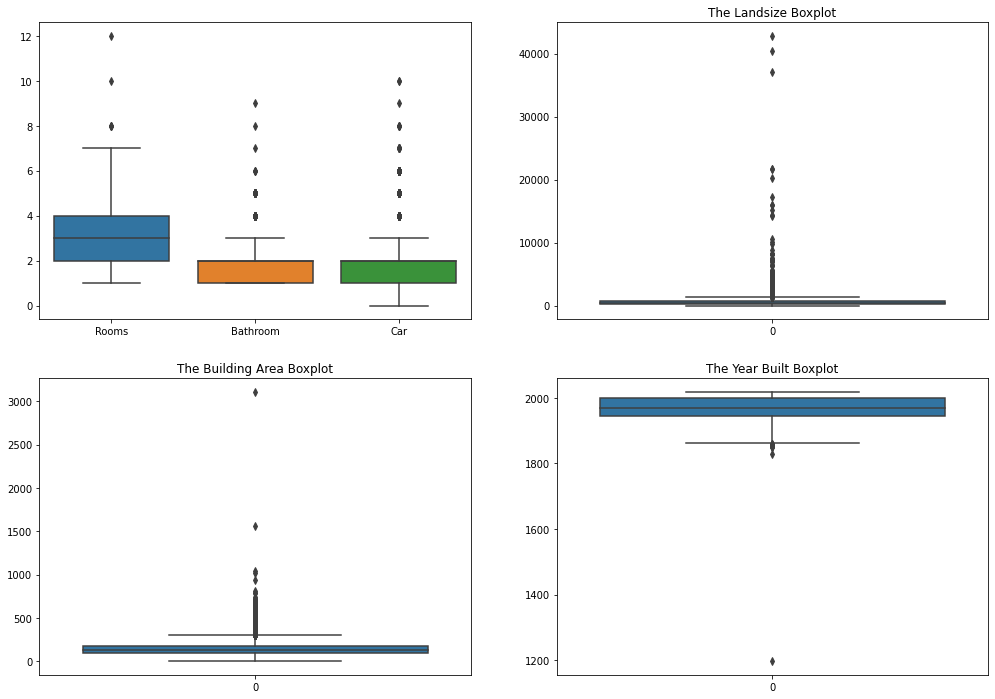

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

nonan_data = data.dropna().reset_index(drop=True)

house_specs = ['Rooms', 'Type', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt']
data_hs = nonan_data[house_specs]

fig, ax = plt.subplots(2, 2, figsize=(17, 12))
sns.boxplot(data=data_hs.drop(['Landsize', 'BuildingArea', 'YearBuilt'], axis=1), ax=ax[0, 0])
sns.boxplot(data=data_hs['Landsize'], ax=ax[0, 1])
ax[0, 1].set_title('The Landsize Boxplot')
sns.boxplot(data=data_hs['BuildingArea'], ax=ax[1, 0])
ax[1, 0].set_title('The Building Area Boxplot')
sns.boxplot(data=data_hs['YearBuilt'], ax=ax[1, 1])
ax[1, 1].set_title('The Year Built Boxplot')
plt.tight_layout

## Making Train Data

In this data, we will prepare the data for training step of **Random Forest Model**.

In [5]:
data.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [6]:
col_train = ['Suburb', 'Rooms', 'Method', 'Date', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
             'YearBuilt', 'Lattitude', 'Longtitude', 'Distance', 'Price']
df_train = data[col_train].dropna().reset_index(drop=True)
df_train['Date'] = pd.to_datetime(df_train['Date'])

df_train['year'] = [x.year for x in df_train['Date']]
df_train['month'] = [x.month for x in df_train['Date']]

In [7]:
df_train.head(3)

,Suburb,Rooms,Method,Date,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Distance,Price,year,month
0,Abbotsford,2,S,2016-04-02,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,2.5,1035000.0,2016,4
1,Abbotsford,3,SP,2017-04-03,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,2.5,1465000.0,2017,4
2,Abbotsford,4,VB,2016-04-06,1.0,2.0,120.0,142.0,2014.0,-37.8072,144.9941,2.5,1600000.0,2016,4


## Making Dataframe for replacement Values

In this step, we will find the replacement values, which is the value that we will use to replace the NaN or outlier data using *close approximation*. This replacement values are *upper extreme, lower extreme* and *mode* or *mean*. 

In [8]:
suburbs = list(df_train.Suburb.value_counts().index)
rep_cols = col_train
for r in ['Method', 'Date', 'Suburb']:
    rep_cols.remove(r) 
stat_cols = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
end_cols = [1, 1, 1, 1, 1, 0, 0, 0, 1, 1]

In [9]:
def search_vals(dx, x, z):
    dx_mean = dx.mean()
    dx_mode = dx.mode()[0]
    
    q1 = dx.quantile(0.25)
    q3 = dx.quantile(0.75)
    iqr = q3 - q1
    
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    
    if x == 0:
        y = dx_mean
    else:
        y = dx_mode
        
    if (z == 1) & (lower < 0):
        lower = 0
        
    if z == 1:
        y = int(y)
        upper = int(upper)
        lower = int(lower)
    
    return round(y, 2), upper, lower

In [10]:
replacement = {}
for s in suburbs:
    app = {}
    for c, i, j in zip(rep_cols, stat_cols, end_cols):
        app[c] = list(search_vals(df_train[df_train['Suburb'] == s][c], i, j))
    replacement[s] = app

### Replacement Values Example

In [11]:
for i in range(4):
    print(suburbs[i], '\n', replacement[suburbs[i]], '\n')

Reservoir 
 {'Rooms': [3, 4, 0], 'Bathroom': [1, 3, 0], 'Car': [1, 3, 0], 'Landsize': [428, 1261, 0], 'BuildingArea': [120, 207, 11], 'YearBuilt': [1974.46, 2085.0, 1869.0], 'Lattitude': [-37.71, -37.683052499999995, -37.74471250000001], 'Longtitude': [145.01, 145.0563625, 144.96334249999998], 'Distance': [11, 13, 9], 'Price': [662421, 1376250, 0]} 

Richmond 
 {'Rooms': [2, 4, 0], 'Bathroom': [1, 3, 0], 'Car': [1, 1, 1], 'Landsize': [633, 546, 0], 'BuildingArea': [101, 202, 0], 'YearBuilt': [1955.01, 2162.5, 1742.5], 'Lattitude': [-37.82, -37.803050000000006, -37.83504999999999], 'Longtitude': [145.0, 145.0255025, 144.97928250000004], 'Distance': [2, 2, 2], 'Price': [1091469, 2444250, 0]} 

Brunswick 
 {'Rooms': [3, 4, 0], 'Bathroom': [1, 3, 0], 'Car': [1, 1, 1], 'Landsize': [341, 722, 0], 'BuildingArea': [129, 250, 0], 'YearBuilt': [1939.55, 2060.75, 1818.75], 'Lattitude': [-37.77, -37.74216249999999, -37.790462500000004], 'Longtitude': [144.96, 144.98194624999996, 144.94157625000003

## Editing Outlier on Train Data

In [12]:
dx_suburb = df_train['Suburb']
for c in rep_cols:
    changed = []
    for i, s in enumerate(dx_suburb):
        v = df_train.loc[i, c]
        u = replacement[s][c][1]
        l = replacement[s][c][2]
        if v > u:
            v = u
        elif v < l:
            v = l
        changed.append(v)
    df_train[c] = changed

In [13]:
df_train.head(3)

,Suburb,Rooms,Method,Date,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Distance,Price,year,month
0,Abbotsford,2,S,2016-04-02,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,2.5,1035000.0,2016,4
1,Abbotsford,3,SP,2017-04-03,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,2.5,1465000.0,2017,4
2,Abbotsford,4,VB,2016-04-06,1.0,1.0,120.0,142.0,2014.0,-37.8072,144.9941,2.5,1600000.0,2016,4


## Train Machine Learning Model to Fill NaN Price

In [14]:
from sklearn.preprocessing import MinMaxScaler

x_cols = ['Rooms', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt',
          'Lattitude', 'Longtitude', 'Distance', 'year', 'month']
train_x = df_train[x_cols]
train_y = df_train['Price']

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

new_train_x = scaler_x.fit_transform(train_x)
new_train_y = scaler_y.fit_transform(np.array(train_y).reshape(-1, 1))

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

x_train, x_valid, y_train, y_valid = train_test_split(new_train_x, new_train_y, test_size=0.2)

rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_valid) 
error = np.sqrt(mean_squared_error(y_pred, y_valid))
error

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.04747603108256157

The Square root of MSE is 0.047 so the prediction doesn't look bad. We can use this model to fill price values with NaN

## Editing All Outlier Data

In [16]:
data.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0


In [17]:
da_suburb = data['Suburb'].value_counts().index
not_in_the_list = []
for d in da_suburb:
    if d not in suburbs:
        not_in_the_list.append(d)
print('The suburb that is not in the list :')
for i, s in enumerate(not_in_the_list):
    print((i+1), s)

The suburb that is not in the list :
1 MacLeod
2 Docklands
3 Laverton
4 Lilydale
5 New Gisborne
6 Heatherton
7 Rockbank
8 Clyde North
9 Warranwood
10 Cranbourne West
11 Eumemmerring
12 Wonga Park
13 Tecoma
14 Silvan
15 Lynbrook
16 Plenty
17 Werribee South
18 Darley
19 Wandin North
20 Monbulk
21 Olinda
22 Menzies Creek
23 Kalkallo
24 Ferny Creek
25 Bulla
26 Belgrave
27 Eynesbury
28 Guys Hill
29 Avonsleigh
30 viewbank
31 Fawkner Lot
32 Coldstream
33 Wildwood
34 croydon
35 Cranbourne East
36 Hopetoun Park


There are 36 suburbs that we haven't found in training dataset. That's quite many. Let's see how many houses sold in this suburbs exist in our data. 

In [18]:
len(data[data.Suburb.isin(not_in_the_list)])

179

There are only 179 data. We can delete all this data.

In [19]:
drop_ind = data[data.Suburb.isin(not_in_the_list)].index
data = data.drop(drop_ind)
data = data.reset_index(drop=True)
data = data.drop(['Bedroom2'], axis=1)

In [20]:
dx_suburb = data['Suburb']
for c in rep_cols:
    changed = []
    for i, s in enumerate(dx_suburb):
        v = data.loc[i, c]
        u = replacement[s][c][1]
        l = replacement[s][c][2]
        if v > u:
            v = u
        elif v < l:
            v = l
        changed.append(v)
    data[c] = changed

## Filling NaN Values Except Price

Now we will fill all the missing values using the replacement values

In [21]:
dfs = data['Suburb']
rep_cols.remove('Price')

for c in rep_cols:
    dfc = data[c]
    null = dfc.isnull()
    changed = []
    for i, d, s in zip(null, dfc, dfs):
        if  i == True:
            d = replacement[s][c][0] 
        changed.append(d)
    data[c] = changed

In [22]:
data.isnull().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price            7565
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bathroom            0
Car                 0
Landsize            0
BuildingArea        0
YearBuilt           0
CouncilArea         2
Lattitude           0
Longtitude          0
Regionname          2
Propertycount       2
dtype: int64

## Filling NaN Price

Now we will fill the NaN value in price using **Random Forest Model** that we already made before. 

In [23]:
data['Date'] = pd.to_datetime(data['Date'])
data['year'] = [x.year for x in data['Date']]
data['month'] = [x.month for x in data['Date']]

In [24]:
from tqdm.auto import tqdm

price_null = data['Price'].isnull()
x_ = scaler_x.transform(data[x_cols])
new_ = []

In [25]:
progress_bar = tqdm(range(len(data)))

for n, i, p in zip(price_null, x_, data['Price']):
    if n == True:
        p = rf_model.predict(i.reshape(1, -1))
        p = scaler_y.inverse_transform(p.reshape(-1, 1))[0, 0]
    new_.append(p)
    progress_bar.update(1)
    
data['Price'] = new_

  0%|          | 0/34678 [00:00<?, ?it/s]

In [26]:
data.isnull().sum()

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      2
Lattitude        0
Longtitude       0
Regionname       2
Propertycount    2
year             0
month            0
dtype: int64

In [27]:
data = data.dropna()
data.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,year,month
0,Abbotsford,68 Studley St,2,h,1188315.0,SS,Jellis,2016-03-09,2.5,3067.0,...,126.0,108.0,1945.41,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0,2016,3
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12,2.5,3067.0,...,202.0,108.0,1945.41,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0,2016,3
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-04-02,2.5,3067.0,...,156.0,79.0,1900.00,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0,2016,4


# **III. Data Analysis**

In [28]:
xr = []
for i in data['Type']:
    if i == 'h':
        xr.append('House')
    elif i == 't':
        xr.append('Townhouse')
    elif i == 'u':
        xr.append('Duplex')
data['Type'] = xr

## Price Fluctuation of Each Type of House

In [29]:
da = data[['Type', 'Date', 'Price']]
dag = da.groupby(by=['Type', 'Date']).mean()

new_dag_type = []
new_dag_date = []
new_dag_price = []

for i, j in zip(dag.index, dag.Price):
    a, b = i
    new_dag_type.append(a)
    new_dag_date.append(b)
    new_dag_price.append(j)
    
new_dag = pd.DataFrame({'type':new_dag_type, 'date':new_dag_date, 'price':new_dag_price})

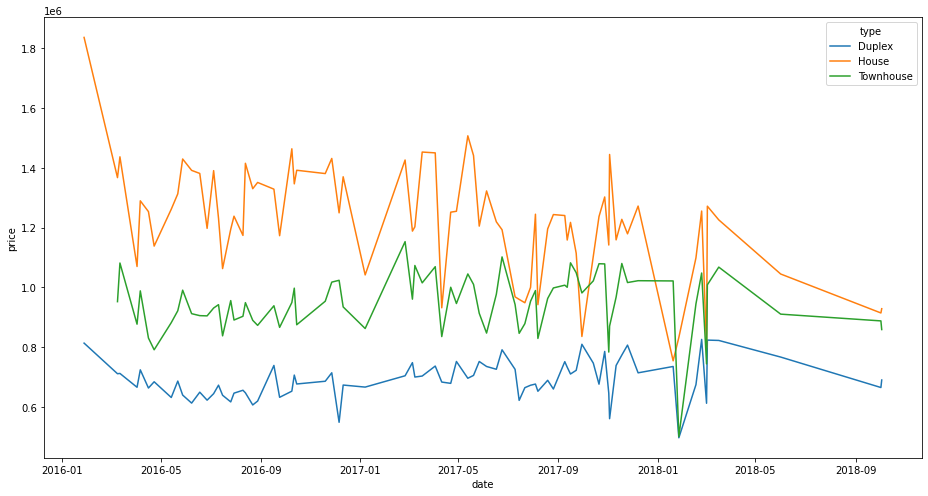

In [30]:
plt.figure(figsize=(13, 7))
sns.lineplot(data=new_dag, x='date', y='price', hue='type')
plt.tight_layout()

As you can see above, House is the most expensive one, then Townhouse, then Duplex. The price of both Duplex and Townhouse was quite stable and consistent. 

**You can say that along 2017 the price is quite unpredictable. Then, at every beginning of the year, the price of the houses declined.**

## House Locations

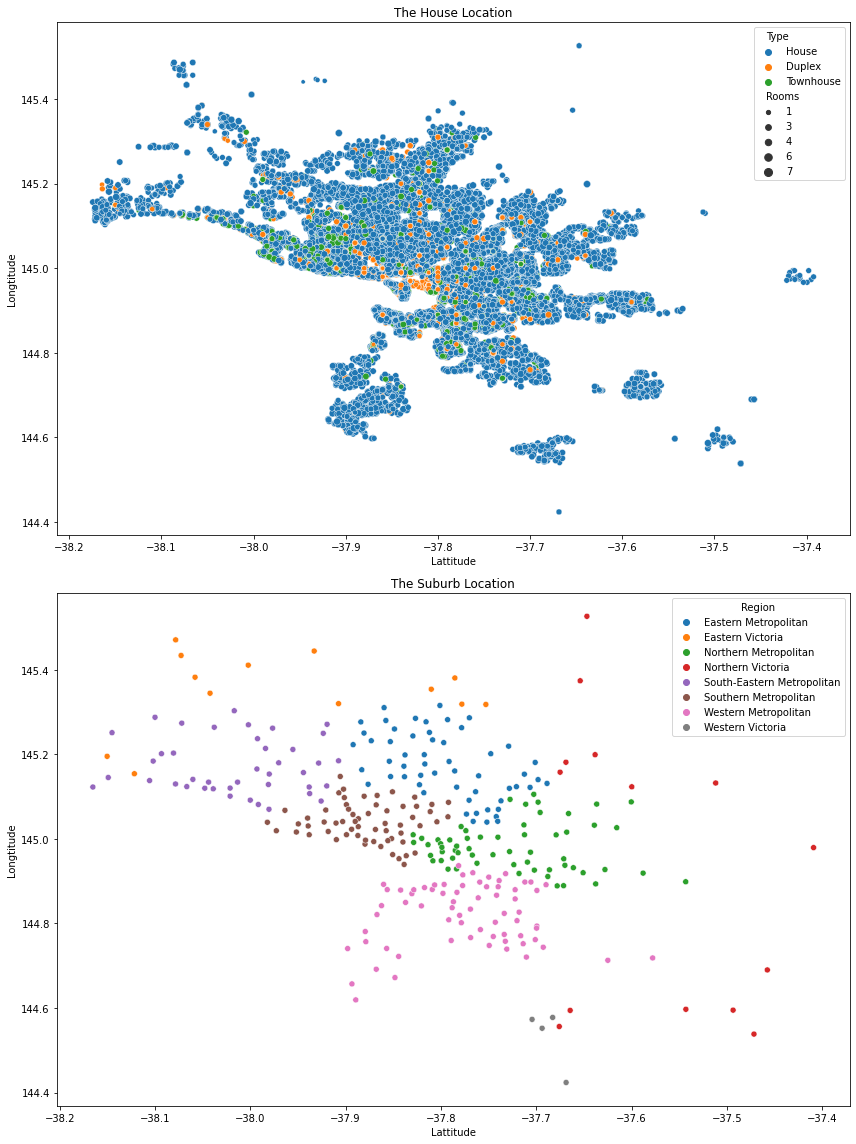

In [31]:
dl = data[['Regionname', 'Suburb', 'Price', 'Lattitude', 'Longtitude']].groupby(by=['Regionname', 'Suburb']).mean()
dl_region = [i for i, j in dl.index]
dl_suburb = [j for i, j in dl.index]

dl['Region'] = dl_region
dl['Suburb'] = dl_suburb
dl = dl.reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 16))
sns.scatterplot(data=data, x='Lattitude', y='Longtitude', hue='Type', size='Rooms', ax=ax[0])
ax[0].set_title('The House Location')
sns.scatterplot(data=dl, x='Lattitude', y='Longtitude', hue='Region', ax=ax[1])
ax[1].set_title('The Suburb Location')
plt.tight_layout()

If you wanted to look closely, at the Victoria area, ther are only a few numbers of houses with the type of Duplex or Townhouse. Most of the type sold here are House type.

## Price Fluctuation in Each Region

Now, we will see how the price fluctuated in regards of their regions. We can classify the regions to two big groups, Metropolitan and Victoria. **Metropolitan** is the region that is located closer to city center compared to **Victoria**, as you can see at the graph from previous section. 

In [32]:
data.Regionname.value_counts()

Southern Metropolitan         11820
Northern Metropolitan          9473
Western Metropolitan           6782
Eastern Metropolitan           4371
South-Eastern Metropolitan     1724
Eastern Victoria                200
Northern Victoria               195
Western Victoria                111
Name: Regionname, dtype: int64

In [33]:
da = data[['Regionname', 'Date', 'Price']].groupby(by=['Regionname', 'Date']).mean()
da_region = []
da_date = []
da_price = []

for i, j in zip(da.index, da['Price']):
    a, b = i
    da_region.append(a)
    da_date.append(b)
    da_price.append(j)
    
new_da = pd.DataFrame({'region':da_region, 'date':da_date, 'price':da_price})

Text(0.5, 1.0, 'Price Fluctuation in Victoria Area')

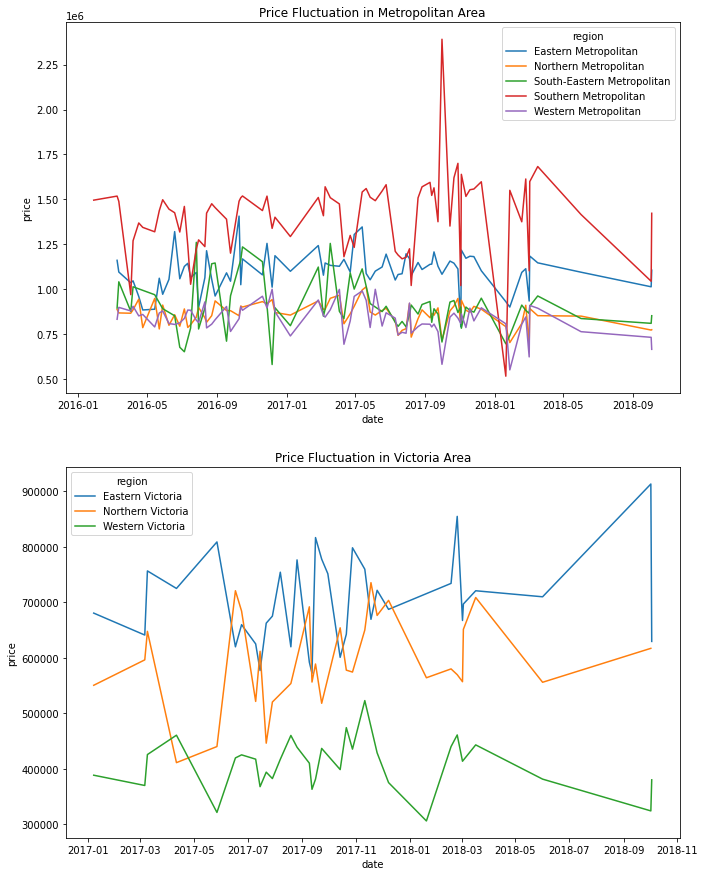

In [34]:
metropolitan = ['Southern Metropolitan', 'Northern Metropolitan', 'Western Metropolitan',
                'Eastern Metropolitan', 'South-Eastern Metropolitan']
victoria = ['Eastern Victoria', 'Northern Victoria', 'Western Victoria']

fig, ax = plt.subplots(2, 1, figsize=(11, 15))
sns.lineplot(data=new_da[new_da.region.isin(metropolitan)], x='date', y='price', hue='region', ax=ax[0])
ax[0].set_title('Price Fluctuation in Metropolitan Area')
sns.lineplot(data=new_da[new_da.region.isin(victoria)], x='date', y='price', hue='region', ax=ax[1])
ax[1].set_title('Price Fluctuation in Victoria Area')

At the **Metropolitan area**, the list of region with the most expensive to the cheapest houses are :
1. Southern Metropolitan - spike at October/ November 2017
2. Eastern Metropolitan
3. South-Eastern Metropolitan - Became same as 4 and 5 around June/July 2017
4. Northern Metropolitan
5. Western Metropolitan

There are two things that we can note here:
1. The price of the house at **Southern Metropolitan** spiked around October - November 2017. Buying property around this time isn't really a good idea.
2. The price of the house at **South-Eastern Metropolitan** got lower and became the same as Northern and Western Metropolitan started from June - July 2017

At the Victoria area, the list of region with the most expensive to the cheapest houses are :
1. Eastern Victoria
2. Northern Victoria
3. Western Victoria

All of these three regions have houses that are sold with lower price than Western Metropolitan. 

## Most Important Attributes

Now, we will see how each factor contributes to the price of a house. The factors that we will be considering are : 
1. Rooms
2. Bathroom
3. Parking car
4. Land size
5. Building Area
6. Location
7. Year Built
8. Distance to the city center
9. House type

We will use **Extra Trees** to determine how each of these 9 factors impact the price.

In [35]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import ExtraTreesRegressor
import scipy

ohe = OneHotEncoder()
types = ohe.fit_transform(np.array(data['Type']).reshape(-1, 1))
types_np = scipy.sparse.csr_matrix.toarray(types)
type_cats = [x.split('_')[1] for x in list(ohe.get_feature_names())]
type_df = pd.DataFrame(types_np, columns=type_cats)

mmf_scaler = MinMaxScaler()
df_f = data[rep_cols]
df_f = pd.DataFrame(mmf_scaler.fit_transform(df_f), columns=rep_cols)
df_f = pd.concat([df_f, type_df], axis=1)

mmf_ = MinMaxScaler()
price_scaled = mmf_.fit_transform(np.array(data['Price']).reshape(-1, 1))

the_tree = ExtraTreesRegressor()
the_tree.fit(df_f, price_scaled)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


ExtraTreesRegressor()

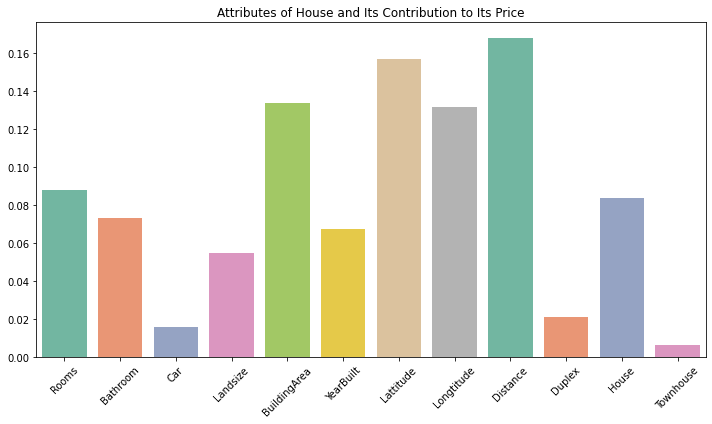

In [36]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df_f.columns, y=the_tree.feature_importances_, palette="Set2")
plt.xticks(rotation=45)
plt.title('Attributes of House and Its Contribution to Its Price')
plt.tight_layout()

As we can see above, location is very important to a price. **The closer a house to the center of the city, the more costly the house would be**. **After its location, the next attribute that is almost that important is its Building area**.

# **IV. Conclusions**

These are some takeaways from this notebook : 

1. **The most important factor that contributes to the price of a house are its distance to the city center and its building area.**
2. **The price of the house always decline around January and February.**
3. **If you are looking for a cheap house located close to Melbourne City Business District, Western Metropolitan is the cheapest region. But if you are really looking for the cheapest house in Melbourne and doesn't really care about its distance to CBD, then Western Victoria is the place for you my friend.**